<a href="https://colab.research.google.com/github/ATKhakimov/QML/blob/main/double_moons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import random

# Pytorch framework
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim

# time libraries
from tqdm.notebook import trange
from time import time

# dataset libraries
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Pennylane QML library
!pip install pennylane
!pip install unrar 
import pennylane as qml
from pennylane import numpy as np


# Seed
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.7 MB/s 
     |████████████████████████████████| 15.3 MB 40.5 MB/s 
     |████████████████████████████████| 145 kB 50.3 MB/s 
     |████████████████████████████████| 1.9 MB 13.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                     random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf.predict_proba(X_test[:1])

clf.predict(X_test[:5, :])

clf.score(X_test, y_test)

0.88

In [ ]:

from datetime import datetime


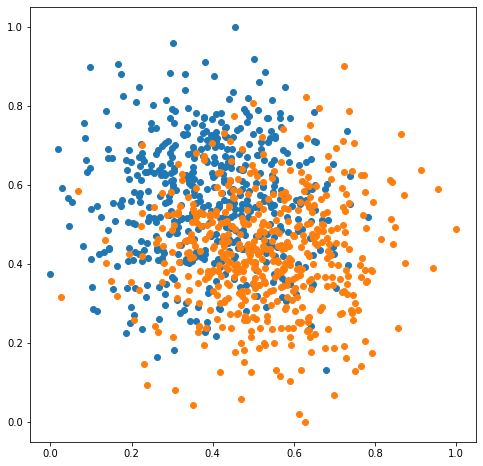

In [ ]:
fig = plt.figure(figsize=(8, 8))
n_noise = 0.8
moon_data, moon_labels = ds.make_moons(1000, shuffle=True, noise=n_noise, random_state=42)
moon_data = MinMaxScaler().fit_transform(moon_data)

plt.scatter(moon_data[moon_labels == 0][:,0], moon_data[moon_labels == 0][:,1], label='0')
plt.scatter(moon_data[moon_labels == 1][:,0], moon_data[moon_labels == 1][:,1], label='1')
# plt.savefig('circles_data.pdf', bbox_inches='tight')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(moon_data, moon_labels, test_size=0.2, random_state=42)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train, y_train = X_train, y_train
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print('\n')
X_test, y_test = X_test, y_test
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (800, 2)
y_train shape: (800, 1)


X_test shape: (200, 2)
y_test shape: (200, 1)


In [ ]:
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
model = SVC(kernel = 'rbf').fit(X_train, y_train)
model1 = SVC(kernel = 'linear').fit(X_train, y_train)
model2 = SVC(kernel = 'poly').fit(X_train, y_train)
model3 = SVC(kernel = 'sigmoid').fit(X_train, y_train)
#model4 = SVC(kernel = 'precomputed').fit(X_train, y_train) not working
print(" rbf :", model.score(X_train, y_train))
print(" linear :",model1.score(X_train, y_train))
print(" poly :",model2.score(X_train, y_train))
print(" sigm :",model3.score(X_train, y_train))
#print(" prec :",model4.score(X_train, y_train))#

 rbf : 0.755
 linear : 0.74875
 poly : 0.71375
 sigm : 0.50625


rbf best for moons!

In [ ]:
y_p = model.predict(X_test)
print(model.score(X_test, y_test))

0.68


Best svc score = **-- %**

In [ ]:
def train(model, X_train, y_train, X_test, y_test, loss_func, optimizer, num_epochs, batch_size, device):
    train_losses = []
    test_accuracy = []
    best_acc = 0
    model.eval() #j
    with torch.no_grad():
        inputs = torch.FloatTensor(X_test).to(device)
        labels = torch.FloatTensor(y_test).to(device)
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        acc = ((outputs >= 0.5) == labels).sum().item()*(100/len(labels))
        test_accuracy.append(acc)
        print("Test acc:", acc)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_batches = len(X_train)//batch_size
        indices = np.arange(len(X_train))
        indices_permuated = np.random.permutation(indices)
        X_train_permuated = X_train[indices_permuated,:]
        y_train_permuated = y_train[indices_permuated,:]

        for batch in range(num_batches):
            X_batch = torch.FloatTensor(X_train_permuated[batch*batch_size:(batch+1)*batch_size]).to(device)
            y_batch = torch.FloatTensor(y_train_permuated[batch*batch_size:(batch+1)*batch_size]).to(device)
            X_batch, y_batch = Variable(X_batch), Variable(y_batch)
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss.item()
  


        model.eval()
        with torch.no_grad():
            inputs = torch.FloatTensor(X_test).to(device)
            labels = torch.FloatTensor(y_test).to(device)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            acc = ((outputs >= 0.5) == labels).sum().item()*(100/len(labels))
            test_accuracy.append(acc)
            #train_losses.append()
        if (acc > best_acc): best_acc = acc
    return train_losses, test_accuracy

In [ ]:
neirons = 100

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
                                    nn.Linear(2, neirons),
                                    nn.ReLU(),
                                    nn.Linear(neirons, 1),
                                    nn.Sigmoid()
                                    )

    def forward(self, inputs):
        return self.layers(inputs)

In [ ]:
# Hyperparameters

print('\n')
num_epochs = 80
mlp_num_epochs = num_epochs
batch_size = 30

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(MLP().to(device))

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
%%time
start_time = datetime.now()
from IPython.display import clear_output 
train_losses_list = []
train_acc_list = []


MLP_model = MLP().to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(MLP_model.parameters(), lr=1e-2)  

train_losses, test_accuracy = train(MLP_model, X_train, y_train, X_test, y_test, loss_func, optimizer, num_epochs, batch_size, device)
mlp_time = (datetime.now() - start_time)



Test acc: 50.0
CPU times: user 1.59 s, sys: 15.9 ms, total: 1.61 s
Wall time: 1.77 s


Best acc: 0.5


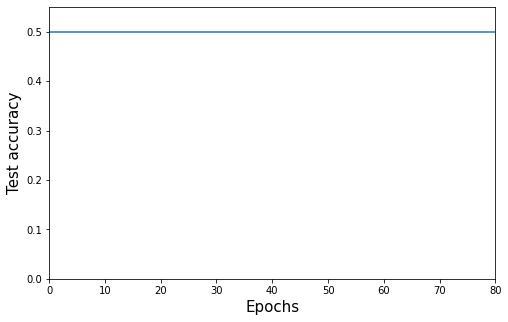

[]


In [ ]:
# test accuracy print
fig = plt.figure(figsize=(8, 5))

plt.plot(np.array(test_accuracy)/100, label = 'classical')
plt.plot(np.array(train_losses)/100, label = 'losses')
print("Best acc:", max(np.array(test_accuracy)/100))
acc = max(np.array(test_accuracy)/100)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Test accuracy', fontsize = 15)
plt.xlim((0, 80))
plt.ylim((0, max(np.array(test_accuracy)/100)+0.05))
plt.show()
print(train_losses)

Quantum NN

все плохо

In [ ]:
# Hyperparameters

print('\n')
num_epochs = 20
q_num_epochs = num_epochs

batch_size = 20
q_batch_size = batch_size
Q_depth = 1

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RX_layer(w):
    for idx, element in enumerate(w):
        qml.RX(element*np.pi, wires=idx)


def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])

In [ ]:
class QNN(nn.Module):
    def __init__(self, num_qubits, c_device, q_device, diff_method):
        super(QNN, self).__init__()

        self.c_device = c_device

        # init device
        self.num_qubits = num_qubits
        self.q_device = qml.device(q_device, wires=self.num_qubits)
        
        # quantum circuit
        @qml.qnode(device =self.q_device, interface="torch", diff_method=diff_method)

        # needfull gates
        def circuit(inputs, weights):

          for i in range(self.num_qubits):
            qml.Hadamard(wires = i)

          qml.RX(np.pi*inputs[0], wires = 0)
          qml.RX(np.pi*inputs[1], wires = 2)
          qml.RZ(np.pi*inputs[0], wires = 0)
          qml.RZ(np.pi*inputs[1], wires = 2)

          for i in range(self.num_qubits-1):
            qml.CNOT(wires = [i, i+1])
          qml.CNOT(wires = [self.num_qubits-1, 0])
          q_depth = Q_depth
          for q in range(q_depth):
            for i in range(self.num_qubits):
              qml.RY(weights[i], wires = i)
          return [qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(3)) ]
        
        weight_shapes = {"weights": self.num_qubits}
        self.circuit = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)
    
    def draw(self):
        # build circuit by sending dummy data through it
        drawer = qml.draw(self.circuit.qnode, show_all_wires=True)
        print(drawer(torch.zeros(self.num_qubits), np.random.rand(self.num_qubits)))
    
    def forward(self, inputs):
        # Quantum node
        batch_size,_ = inputs.size()
        q_out = torch.zeros((batch_size,1))
        q_out = Variable(q_out)
        for i in range(batch_size):
          q_res = self.circuit(inputs = inputs[i, :])
          q_out[i] = ((torch.mean(q_res) + torch.Tensor([1.0]))/ 2.0).reshape(-1,1)
        return q_out

In [ ]:
%%time
start_ttime = datetime.now()
from IPython.display import clear_output 
q_train_losses_list = []
q_train_acc_list = []


n_qubits = 4

QNN_model = QNN(num_qubits= n_qubits, c_device = device, q_device = "lightning.qubit", diff_method ="adjoint").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(QNN_model.parameters(), lr=1e-2)


q_train_losses, q_test_accuracy = train(QNN_model, X_train, y_train, X_test, y_test, loss_func, optimizer, num_epochs, batch_size, device)
q_train_losses_list.append(q_train_losses)
q_train_acc_list.append(q_test_accuracy)
qnn_time = datetime.now()-start_ttime

Test acc: 54.0
CPU times: user 1min 23s, sys: 748 ms, total: 1min 24s
Wall time: 1min 33s


Best q_acc: 0.72


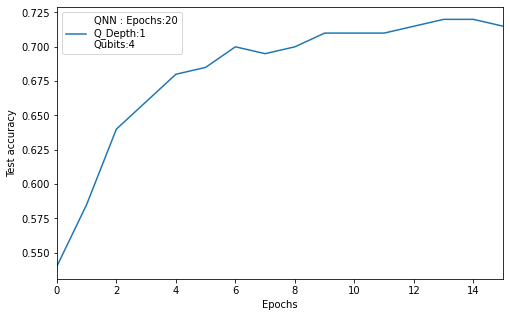

In [ ]:
# plot test accuracy
fig = plt.figure(figsize=(8, 5))
print("Best q_acc:", max(np.array(q_test_accuracy)/100))
q_acc =  max(np.array(q_test_accuracy)/100)
plt.plot(np.array(q_train_acc_list[0])/100, label = 'QNN : ' + 'Epochs:' + str(num_epochs) + "\n" + 'Q_Depth:' + str(Q_depth) + "\n" + 'Qubits:' + str(n_qubits))
dx = 5
plt.xlim((0, 15))
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.legend()

plt.show()

In [ ]:
# quantum circuit
QNN(4, "cpu", "default.qubit", diff_method = "adjoint").draw()

0: ──H──RX(0.00)──RZ(0.00)─╭●───────╭X──RY(0.15)─┤     
1: ──H─────────────────────╰X─╭●────│───RY(0.58)─┤  <Z>
2: ──H──RX(0.00)──RZ(0.00)────╰X─╭●─│───RY(0.81)─┤     
3: ──H───────────────────────────╰X─╰●──RY(0.58)─┤  <Z>


In [ ]:
def info(n_type, amount_cu, amount_e, time, d_noise, best_acc):
  print(
                    "Type: {} Amount of computing units: {} Anount of epoch: {} Training time: {} Dataset noise: {} Bedt accuracy: {}".format(
                        n_type,
                        amount_cu,
                        amount_e,
                        time,
                        d_noise,
                       best_acc,
                    ),
                    end="\n",
                )

In [ ]:
info("QNN", n_qubits, q_num_epochs, qnn_time, n_noise, q_acc)
info("MLP", neirons , mlp_num_epochs, mlp_time, n_noise, acc)

Type: QNN Amount of computing units: 4 Anount of epoch: 20 Training time: 0:01:33.637790 Dataset noise: 0.8 Bedt accuracy: 0.72
Type: MLP Amount of computing units: 1 Anount of epoch: 80 Training time: 0:00:01.774788 Dataset noise: 0.8 Bedt accuracy: 0.5


In [ ]:
!pip install pylatexenc
import pylatexenc
!pip install qiskit
import matplotlib
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 15.3 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=fcab70ba925b6c355e6d1bca7943ab3cc224db5f61cdf048254c3ba986b13fdc
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 16.2 MB/s 
     |████████████████████████████████| 19.2 MB 1.3 MB/s 
     |████████████████████████████████| 240 kB 60.6 MB/s 
     |████████████████████████████████| 106 kB 6.5 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 943 kB 64.8 MB/s 
     |████████████████████████████████| 50 kB 6.

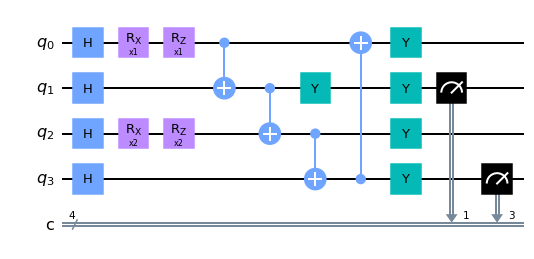

In [ ]:
x1 = Parameter('x1')
x2 = Parameter('x2')
circuit = QuantumCircuit(4, 4)
circuit.h(range(4))
circuit.rx(x1, 0)
circuit.rz(x1, 0)
circuit.rx(x2, 2)
circuit.rz(x2, 2)
circuit.cnot(0, 1)
circuit.cnot(1, 2)
circuit.cnot(2, 3)
circuit.cnot(3, 0)
circuit.y(0)
circuit.y(3)
circuit.y(2)
circuit.y(1)
circuit.y(1)

circuit.measure(1, 1)
circuit.measure(3, 3)
circuit.draw('mpl')